# Задача 7

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as st
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 13

## Загрузка

In [2]:
!wget -O ak_en.txt http://www.gutenberg.org/files/1399/1399-0.txt

--2019-03-19 03:06:49--  http://www.gutenberg.org/files/1399/1399-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2068089 (2,0M) [text/plain]
Saving to: ‘ak_en.txt’

ak_en.txt           100%[===================>]   1,97M   998KB/s    in 2,0s    

2019-03-19 03:06:52 (998 KB/s) - ‘ak_en.txt’ saved [2068089/2068089]



In [29]:
!wget -O ak_fr.txt http://www.gutenberg.org/ebooks/17552.txt.utf-8

--2019-03-19 03:19:23--  http://www.gutenberg.org/ebooks/17552.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/17552/pg17552.txt [following]
--2019-03-19 03:19:24--  http://www.gutenberg.org/cache/epub/17552/pg17552.txt
Reusing existing connection to www.gutenberg.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 812405 (793K) [text/plain]
Saving to: ‘ak_fr.txt’

ak_fr.txt           100%[===================>] 793,36K   438KB/s    in 1,8s    

2019-03-19 03:19:26 (438 KB/s) - ‘ak_fr.txt’ saved [812405/812405]



In [2]:
def words_from_file(path):
    fd = open(path)
    text = fd.read()
    fd.close()
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    return words

## Сравнение языков

In [148]:
en_words = words_from_file('ak_en.txt')
en_lens = np.array([len(word) for word in en_words], dtype=np.int)
print('Mode = {}\nMedian = {}\nMean = {}'.format(st.mode(en_lens).mode[0],
                                                 int(np.median(en_lens)),
                                                 np.mean(en_lens)))

Mode = 3
Median = 4
Mean = 4.260693572942311


Наиболее "интересное" среднее - мода, т.е. самая распространенная длина слова.

In [149]:
fr_words = words_from_file('ak_fr.txt')
fr_lens = np.array([len(word) for word in fr_words], dtype=np.int)
print('Mode = {}\nMedian = {}\nMean = {}'.format(st.mode(fr_lens).mode[0],
                                                 int(np.median(fr_lens)),
                                                 np.mean(fr_lens)))

Mode = 2
Median = 4
Mean = 4.3762383381556065


In [150]:
ru_words = words_from_file('ak_ru.txt')
ru_lens = np.array([len(word) for word in ru_words], dtype=np.int)
print('Mode = {}\nMedian = {}\nMean = {}'.format(st.mode(ru_lens).mode[0],
                                                 int(np.median(ru_lens)),
                                                 np.mean(ru_lens)))

Mode = 3
Median = 5
Mean = 4.945011699246458


### Замечание:
Медианы и средние почти одинаковые, а вот моды отличаются: во французском преобладают слова из двух букв, в русском и английском - из трех. Средняя длина слова в русском языке наибольшая.

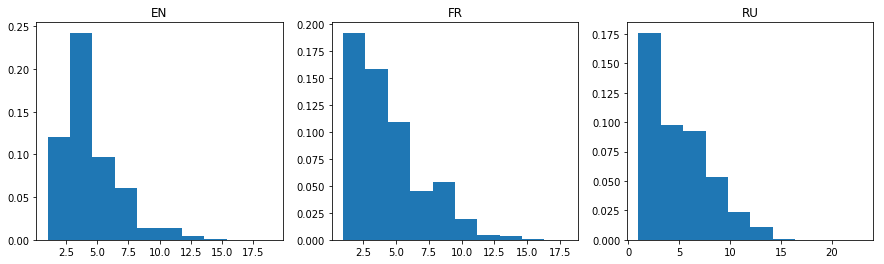

In [156]:
plt.rcParams['figure.figsize'] = (15, 4)
ax1, ax2, ax3 = plt.subplots(1, 3)[1]
ax1.set_title('EN'), ax2.set_title('FR'), ax3.set_title('RU')
ax1.hist(en_lens, density=True)
ax2.hist(fr_lens, density=True)
ax3.hist(ru_lens, density=True)
_ = plt.show()

Будем исходить из того, что распределение - пуассоновское (так дано свыше в условии задачи).

Тогда оценим параметр распределения.

### Оценка параметра

В качестве оценки возьмем оценку максимального правдоподобия. Для пуассоновского распределения:

$$
\xi \sim Poiss(\lambda), \quad \lambda_{MLE} = \bar{X}
$$

In [159]:
en_mle, fr_mle, ru_mle = np.mean(en_lens), np.mean(fr_lens), np.mean(ru_lens)

Будем проверять гипотезу о том, что $\lambda = \lambda_0$. В качестве $\lambda_0$ будем брать ОМП для других языков. Таким образом наша гипотеза эквивалентна тому, что длины слов распределены одинаково.

Будем использовать хи-квадрат тест.

In [205]:
def prepare(_lens):
    c = Counter(_lens)
    items = sorted(c.items())
    max_len = items[-1][0]
    for i in range(max_len):
        if i + 1 not in c:
            c[i + 1] = 0
    items = sorted(c.items())
    values = [v for i, v in items]
    return np.array(values)

In [206]:
EN, FR, RU = prepare(en_lens), prepare(fr_lens), prepare(ru_lens)

In [189]:
en_rv = st.poisson(en_mle)
fr_rv = st.poisson(fr_mle)
ru_rv = st.poisson(ru_mle)

In [215]:
size = max(len(EN) + 1, len(FR) + 1, len(RU) + 1)
en_probs = np.array([en_rv.pmf(i) for i in range(0, size)])
fr_probs = np.array([fr_rv.pmf(i) for i in range(0, size)])
ru_probs = np.array([ru_rv.pmf(i) for i in range(0, size)])

Тестируем EN на совпадение с остальными:

In [260]:
rejects = []
for probs in (fr_probs, ru_probs):
    pval = st.chisquare(EN, probs[:len(EN)] * len(EN), ddof=len(EN) - 2).pvalue
    rejects.append(pval <= 0.05)
rejects

[True, True]

Таким образом, отклонить гипотезы о том, что распределение одинаковое, нужно в обоих случаях.

Для остальных проделаем такую же процедуру.

In [259]:
rejects = []
for probs in (en_probs, ru_probs):
    pval = st.chisquare(FR, probs[:len(FR)] * len(FR), ddof=len(FR) - 2).pvalue
    rejects.append(pval <= 0.05)
rejects

[True, True]

In [258]:
rejects = []
for probs in (en_probs, fr_probs):
    pval = st.chisquare(RU, probs[:len(RU)] * len(RU), ddof=len(RU) - 2).pvalue
    rejects.append(pval <= 0.05)
rejects

[True, True]

Итак, гипотезы об одинаковости распределений отклонены во всех случаях. В разных языках **распределение не одинаковое**.

## Сравнение жанров

In [266]:
news_words = words_from_file('news.2008.ru.shuffled')
news_lens = np.array([len(word) for word in news_words], dtype=np.int)

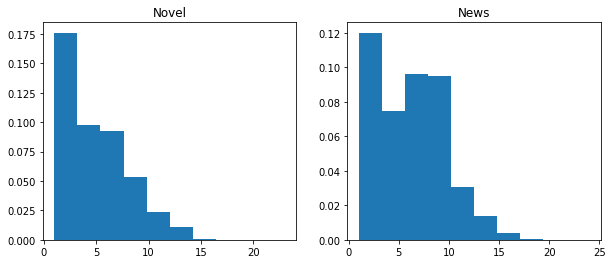

In [269]:
plt.rcParams['figure.figsize'] = (10, 4)
ax1, ax2 = plt.subplots(1, 2)[1]
ax1.set_title('Novel'), ax2.set_title('News')
ax1.hist(ru_lens, density=True)
ax2.hist(news_lens, density=True)
_ = plt.show()

Будем использовать тест Колмогорова-Смирнова для двух выборок:

In [270]:
st.ks_2samp(news_lens, ru_lens)

Ks_2sampResult(statistic=0.15384035344693664, pvalue=0.0)

Таким образом, гипотеза об одинаковости распределения **отвергается**.